# Prédiction de la position d'objets connectés

Les objets connectés envoient à des intervalles de temps réguliers des messages qui tansitent par le réseau GSM. Des antennes appelées stations de base reçoivent ces messages et sont chargées de les transmettre via un réseau filaire. Notre objectif est d'implémenter un algorithme d'apprentissage automatique pour prédire la position d'un objet à partir des messages réceptionnés par les stations de base.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import math
from scipy.stats import gaussian_kde
from geopy.distance import vincenty
import time

from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

%matplotlib inline

## Chargement des données

In [2]:
train = pd.read_csv("mess_train_list.csv")
test = pd.read_csv("mess_test_list.csv")
train_label = pd.read_csv("pos_train_list.csv")

In [3]:
print("Training set:", train.shape)
train[:5]

Training set: (39250, 8)


,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
print("Train set position:", train_label.shape)
train_label[:5]

Train set position: (39250, 2)


,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [5]:
print("Test set:", test.shape)
test[:5]

Test set: (29286, 8)


,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


## Exploration des données

### Nombre de stations recevant un même message

Messages reçus par 3 stations de base ou plus: 62.39 %
Messages reçus par moins de 3 stations: 37.61 %
Messages reçus par une station: 21.90 %


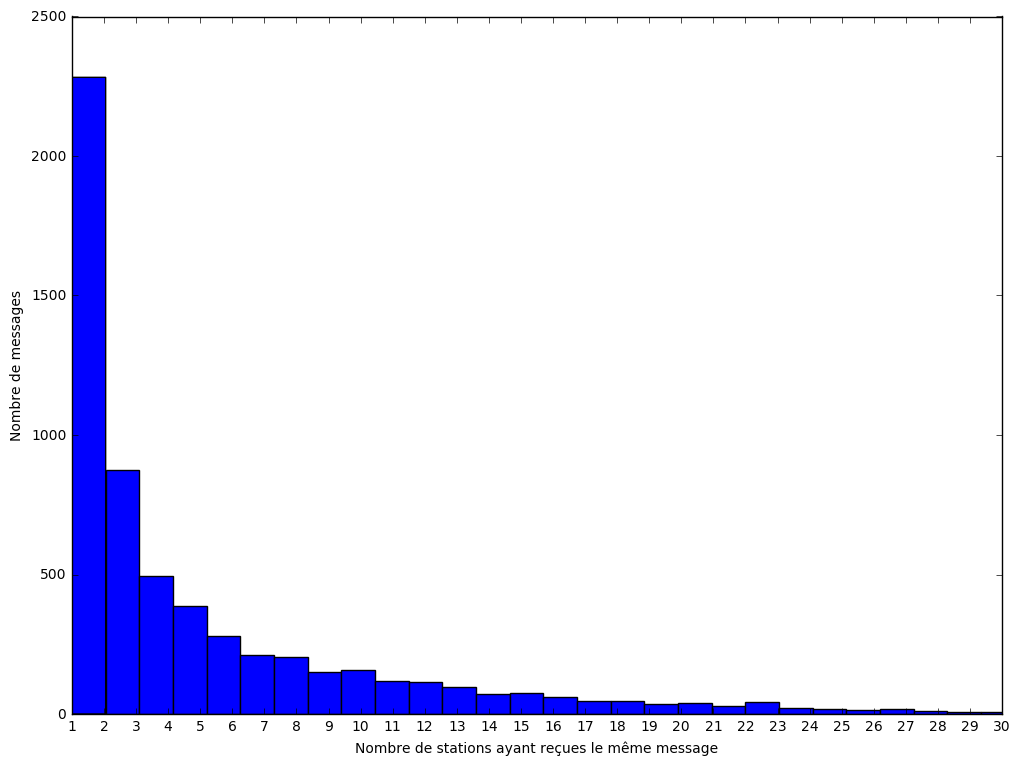

In [6]:
data = train.groupby("objid").count()["bsid"]
data_with_3_pos = data[data>=3].count()
data_with_3_pos_less = data[data<3].count()
data_with_1_pos = data[data==1].count()

print("Messages reçus par 3 stations de base ou plus: %2.2f" %(data_with_3_pos / data.count() * 100), "%")
print("Messages reçus par moins de 3 stations: %2.2f" %(data_with_3_pos_less / data.count() * 100), "%")
print("Messages reçus par une station: %2.2f" %(data_with_1_pos / data.count() * 100), "%")

plt.figure(figsize=(12,9))
plt.hist(data, bins= 100)
plt.xlabel("Nombre de stations ayant reçues le même message")
plt.ylabel("Nombre de messages")
plt.xlim([1, 30])
plt.xticks(np.arange(1, 30+1, 1.0))
plt.show()

In [7]:
listOfBs = np.union1d(np.unique(train['bsid']), np.unique(test['bsid']))
print("Nombre de stations ayant reçues au moins un message %d" %(len(listOfBs)))

Nombre de stations ayant reçues au moins un message 259


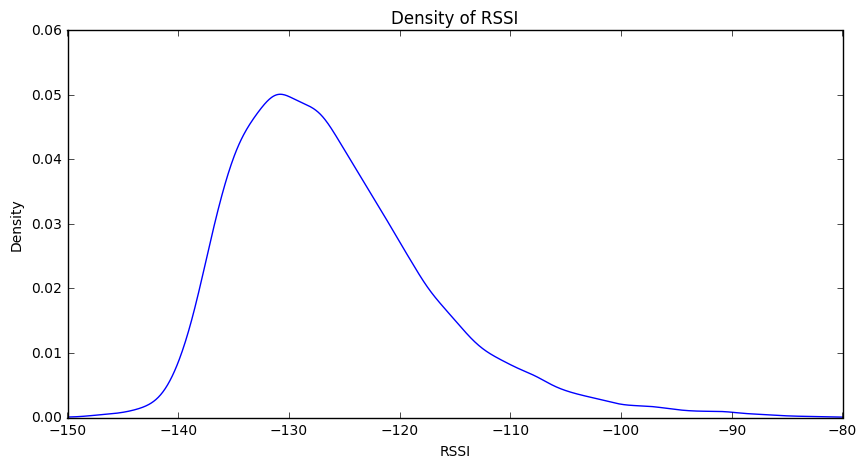

In [8]:
plt.figure(figsize=(10, 5))
kernel = gaussian_kde(train["rssi"])
xx = np.linspace(-150, -80, 1000)
plt.plot(xx, kernel(xx))
plt.xlabel("RSSI")
plt.ylabel("Density")
_ = plt.title("Density of RSSI")

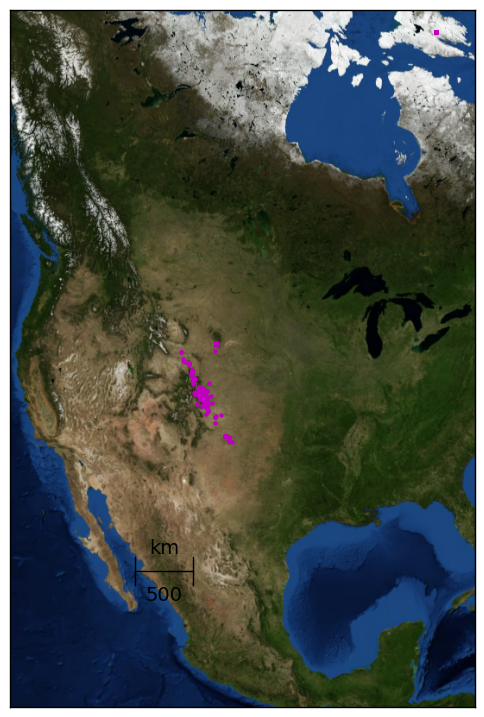

In [10]:
plt.figure(figsize=(15, 9))
mp = Basemap(width=4000000, height=6000000, projection='lcc',
            resolution='i', lat_0=train["bs_lat"].mean(), lon_0=train["bs_lng"].mean())
mp.bluemarble()
mp.scatter(train["bs_lng"].values, train["bs_lat"].values,
       latlon=True,  marker='.',color='m')

_ = mp.drawmapscale(train["bs_lng"].min(), train["bs_lat"].min() - 10,
                 2 * train["bs_lng"].max() - train["bs_lng"].min(), train["bs_lat"].min() - 10,
                 500, fontsize = 14)

## Régression

Quelles caractéristiques chosir pour notre modèle ?

### Feature Matrix construction


#### Message received or not

In [12]:
def feat_mat_const(train, listOfBs):
    
    messages = train["objid"].unique()
    df_feat = pd.DataFrame(index= messages, columns=listOfBs).fillna(0)
    
    # Pour chaque station recevant le message
    # Affecter la valeur du signal correspondant
    for message in messages:
        bsids = train[train["objid"] == message]["bsid"]
        df_feat.loc[message, bsids] = 1
    
    return df_feat

#### Message received with rssi or not

In [13]:
def feat_mat_const(train, listOfBs):
    
    # Pour chaque station ne recevant pas de message
    # Affecter la plus petite valeur existante auquelle on retranchera 10
    min_rssi = train["rssi"].min() - 10000
    messages = train["objid"].unique()
    df_feat = pd.DataFrame(index= messages, columns=listOfBs).fillna(min_rssi)
    
    # Pour chaque station recevant le message
    # Affecter la valeur du signal correspondant
    for message in messages:
        bsids = train[train["objid"] == message]["bsid"]
        for bsid in bsids:
            df_feat.loc[message, bsid] = train[(train["objid"] == message) & (train["bsid"] == bsid)]["rssi"].iloc[0]
    
    return df_feat

#### Message received with location

In [15]:
def feat_mat_const(train, listOfBs):
    
    min_lat = train["bs_lat"].mean()
    min_lng = train["bs_lng"].mean()
    messages = train["objid"].unique()
    columns = []
    list(map(lambda bs: columns.append("lat_" + str(bs)), listOfBs))
    list(map(lambda bs: columns.append("lng_" + str(bs)), listOfBs))
    
    df_feat = pd.DataFrame(index= messages, columns=columns)
    df_feat[df_feat.columns[:len(listOfBs)]] = df_feat[df_feat.columns[:len(listOfBs)]].fillna(min_lat)
    df_feat[df_feat.columns[len(listOfBs):]] = df_feat[df_feat.columns[len(listOfBs):]].fillna(min_lng)
    
    # Pour chaque station recevant le message
    for message in messages:
        bsids = train[train["objid"] == message]["bsid"]
        for bsid in bsids:
            lat = train[(train["objid"] == message) & (train["bsid"] == bsid)]["bs_lat"].iloc[0]
            lng = train[(train["objid"] == message) & (train["bsid"] == bsid)]["bs_lng"].iloc[0]
            df_feat.loc[message, ("lat_" + str(bsid))] = lat
            df_feat.loc[message, ("lng_" + str(bsid))] = lng
    
    return df_feat

#### Message received with location and rssi

In [16]:
def feat_mat_const(train, listOfBs):
    
    min_rssi = train["rssi"].min() - 10000
    min_rssi_lat = train["bs_lat"].mean() * min_rssi
    min_rssi_lng = train["bs_lng"].mean() * min_rssi
    messages = train["objid"].unique()
    columns = []
    list(map(lambda bs: columns.append("lat_" + str(bs)), listOfBs))
    list(map(lambda bs: columns.append("lng_" + str(bs)), listOfBs))
    
    df_feat = pd.DataFrame(index= messages, columns= columns)
    df_feat[df_feat.columns[:len(listOfBs)]] = df_feat[df_feat.columns[:len(listOfBs)]].fillna(min_rssi_lat)
    df_feat[df_feat.columns[len(listOfBs):]] = df_feat[df_feat.columns[len(listOfBs):]].fillna(min_rssi_lng)
    
    # Pour chaque station recevant le message
    for message in messages:
        bsids = train[train["objid"] == message]["bsid"]
        for bsid in bsids:
            lat = train[(train["objid"] == message) & (train["bsid"] == bsid)]["bs_lat"].iloc[0]
            lng = train[(train["objid"] == message) & (train["bsid"] == bsid)]["bs_lng"].iloc[0]
            rssi = train[(train["objid"] == message) & (train["bsid"] == bsid)]["rssi"].iloc[0]
            df_feat.loc[message, ("lat_" + str(bsid))] = lat * rssi
            df_feat.loc[message, ("lng_" + str(bsid))] = lng * rssi
    
    return df_feat

La dernière proposition de construction de matrice d'observation est celle retenue par la suite.

### Ground truth construction

In [17]:
def ground_truth_const(train, train_label):
    train_set = train.copy()
    train_set[["lat", "lng"]] = train_label
    ground_truth_lat = train_set.groupby("objid").mean()["lat"]
    ground_truth_lng = train_set.groupby("objid").mean()["lng"]
    return ground_truth_lat, ground_truth_lng

In [18]:
t0 = time.time()
X_train = feat_mat_const(train, listOfBs)
X_test = feat_mat_const(test, listOfBs)

print("Built features matrix in %s seconds" %(time.time() - t0))

y_lat, y_lng = ground_truth_const(train, train_label)

Built features matrix in 698.4292361736298 seconds


In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_lat.shape)
print(y_lng.shape)
X_train.head()

(6068, 518)
(5294, 518)
(6068,)
(6068,)


,lat_879,lat_911,lat_921,lat_944,lat_980,lat_1012,lat_1086,lat_1092,lat_1120,lat_1131,...,lng_9936,lng_9941,lng_9949,lng_10134,lng_10148,lng_10151,lng_10162,lng_10999,lng_11007,lng_11951
573bf1d9864fce1a9af8c5c9,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,...,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06
573bf3533e952e19126b256a,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,...,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06
573c0cd0f0fe6e735a699b93,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,...,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06
573c1272f0fe6e735a6cb8bd,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,...,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06
573c8ea8864fce1a9a5fbf7a,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-432146.003811,-5636.333280,-432146.003811,-432146.003811,-432146.003811,...,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06,1.025347e+06


### Scaling

In [21]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns)
X_train.head()

,lat_879,lat_911,lat_921,lat_944,lat_980,lat_1012,lat_1086,lat_1092,lat_1120,lat_1131,...,lng_9936,lng_9941,lng_9949,lng_10134,lng_10148,lng_10151,lng_10162,lng_10999,lng_11007,lng_11951
0,-0.012838,-0.012838,-0.012838,-0.022241,-0.036334,-0.119193,-0.105664,-0.072812,-0.012838,-1.0,...,1.0,1.0,1.0,0.036334,0.018158,0.240966,0.330334,0.012838,0.217879,0.012838
1,-0.012838,-0.012838,-0.012838,-0.022241,-0.036334,-0.119193,-0.105664,-0.072812,-0.012838,-1.0,...,1.0,1.0,1.0,0.036334,0.018158,0.240966,0.330334,0.012838,0.217879,0.012838
2,-0.012838,-0.012838,-0.012838,-0.022241,-0.036334,-0.119193,-0.105664,-0.072812,-0.012838,-1.0,...,1.0,1.0,1.0,0.036334,0.018158,0.240966,0.330334,0.012838,0.217879,0.012838
3,-0.012838,-0.012838,-0.012838,-0.022241,-0.036334,-0.119193,-0.105664,-0.072812,-0.012838,-1.0,...,1.0,1.0,1.0,0.036334,0.018158,0.240966,0.330334,0.012838,0.217879,0.012838
4,-0.012838,-0.012838,-0.012838,-0.022241,-0.036334,-0.119193,9.460168,-0.072812,-0.012838,-1.0,...,1.0,1.0,1.0,0.036334,0.018158,0.240966,0.330334,0.012838,0.217879,0.012838


### Measure error

In [22]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [23]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat, y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

### Select hyper parameters

In [26]:
def regressor_and_predict_CV(reg, parameters, df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat)
    reg = GridSearchCV(reg, parameters, cv=10)
    
    reg.fit(X_train, ground_truth_lat)
    y_pred_lat = reg.predict(df_test)
    print("Best latitude estimator:", reg.best_estimator_)

    reg.fit(X_train, ground_truth_lng)
    y_pred_lng = reg.predict(df_test)
    print("Best longitude estimator:", reg.best_estimator_)
    
    return y_pred_lat, y_pred_lng

#### Régression linéaire basique

In [27]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    parameters = {
        'fit_intercept': [True, False]
    }
    """poly = PolynomialFeatures(2)
    print(df_feat.shape)
    df_feat = poly.fit_transform(df_feat)
    df_test = poly.fit_transform(df_test)
    print(df_feat.shape)"""
    reg = linear_model.LinearRegression(n_jobs=-1)
    return regressor_and_predict_CV(reg, parameters, df_feat, ground_truth_lat, ground_truth_lng, df_test)

#### Forêt aléatoire

In [30]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    parameters = {
        'criterion': ["mse"]
    }
    reg = RandomForestRegressor(n_estimators=1000, max_depth=10, n_jobs=-1)
    
    return regressor_and_predict_CV(reg, parameters, df_feat, ground_truth_lat, ground_truth_lng, df_test)

#### Extra Forêt

In [29]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    parameters = {
        'max_depth': [1, 5, 10, 20]
    }
    reg = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    return regressor_and_predict_CV(reg, parameters, df_feat, ground_truth_lat, ground_truth_lng, df_test)

In [31]:
random_seed = 13
X_train_b, X_val, y_train, y_val = train_test_split(X_train, np.transpose([y_lat, y_lng]),
                                                    train_size=0.9, random_state=random_seed)

# Learning on a part of the training set
# Predicting on another small part of the training set
y_pred_lat, y_pred_lng = regressor_and_predict(X_train_b, y_train[:, 0], y_train[:, 1], X_val)

# Measuring error on the small part of the training set not used for learning
err_vec = Eval_geoloc(y_val[:, 0] , y_val[:, 1], y_pred_lat, y_pred_lng)

Best latitude estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
Best longitude estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)


### Model validation

In [32]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng):
    
    X_train = np.array(df_feat)
    
    # Multiple output regressor
    reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=1000, n_jobs=-1))
    y = pd.concat([ground_truth_lat, ground_truth_lng], axis=1)
    y_pred = cross_val_predict(reg, df_feat, y, cv=10)
    y_pred_lat = y_pred[:, 0]
    y_pred_lng = y_pred[:, 1]
    
    # Multiple regressors
    """reg = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
    y_pred_lat = cross_val_predict(reg, df_feat, ground_truth_lat, cv=10)
    y_pred_lng = cross_val_predict(reg, df_feat, ground_truth_lng, cv=10)"""
    
    return y_pred_lat, y_pred_lng

# Learning and predicting on full training set
y_pred_lat, y_pred_lng = regressor_and_predict(X_train, y_lat, y_lng)
# Measuring error on the full training set
err_vec = Eval_geoloc(y_lat, y_lng, y_pred_lat, y_pred_lng)

### Distribution of errors

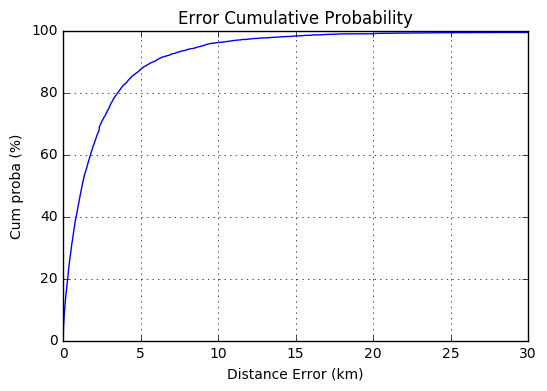

In [33]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values)
plt.figure()
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid()
plt.xlabel('Distance Error (km)')
plt.ylabel('Cum proba (%)')
plt.axis([0, 30, 0, 100])
_ = plt.title('Error Cumulative Probability')

In [34]:
print("Critère de prédiction: %2.2f km" %(np.percentile(err_vec, 80) / 1000))

Critère de prédiction: 3.54 km


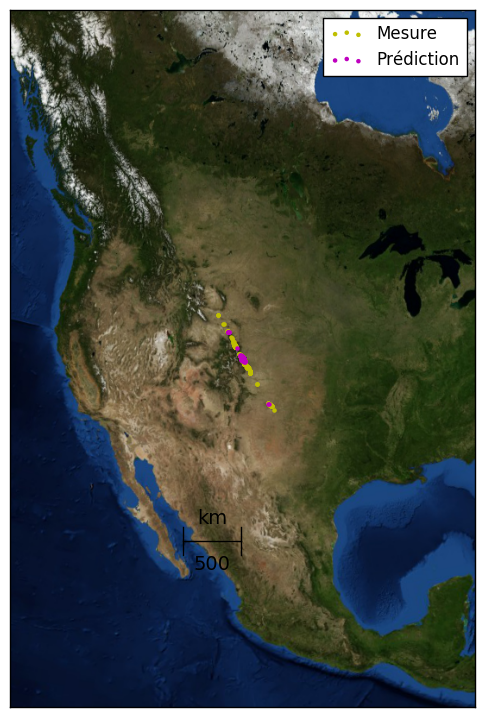

In [39]:
# Données de tests et prédictions
plt.figure(figsize=(15, 9))
mp = Basemap(width=4000000, height=6000000, projection='lcc',
            resolution='i', lat_0=y_lat.mean(), lon_0=y_lng.mean())
mp.bluemarble()
mp.scatter(y_lng.values, y_lat.values, latlon=True, marker='.', color='y', label="Mesure")
mp.scatter(y_pred_lng, y_pred_lat, latlon=True, marker='.', color='m', label="Prédiction")

plt.legend(loc="best")
_ = mp.drawmapscale(y_lng.min(), y_lat.min() - 10, 2 * y_lng.max() - y_lng.min(),
                    y_lat.min() - 10, 500, fontsize = 14)

## Résultat

In [36]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    X_train = np.array(df_feat)
    reg = RandomForestRegressor(n_estimators=1000, n_jobs=-1)    
    
    reg.fit(X_train, ground_truth_lat)
    y_pred_lat = reg.predict(df_test)

    reg.fit(X_train, ground_truth_lng)
    y_pred_lng = reg.predict(df_test)
    
    return y_pred_lat, y_pred_lng

y_pred_lat, y_pred_lng = regressor_and_predict(X_train, y_lat, y_lng, X_test)

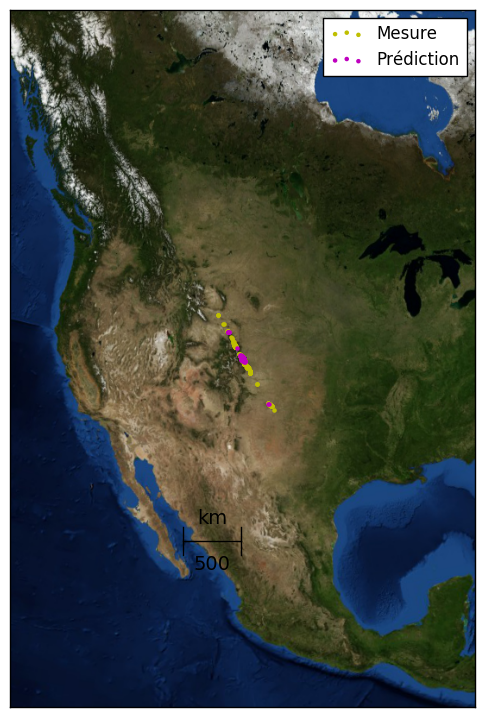

In [40]:
# Données de tests et prédictions
plt.figure(figsize=(15, 9))
mp = Basemap(width=4000000, height=6000000, projection='lcc',
            resolution='i', lat_0=y_lat.mean(), lon_0=y_lng.mean())
mp.bluemarble()
mp.scatter(y_lng.values, y_lat.values, latlon=True, marker='.', color='y', label="Mesure")
mp.scatter(y_pred_lng, y_pred_lat, latlon=True, marker='.', color='m', label="Prédiction")

plt.legend(loc="best")
_ = mp.drawmapscale(y_lng.min(), y_lat.min() - 10, 2 * y_lng.max() - y_lng.min(),
                    y_lat.min() - 10, 500, fontsize = 14)

In [38]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list.csv', index=False)

test_res.head()

,lat,lng
0,39.717294,-105.088569
1,39.783026,-105.071437
2,39.689990,-105.005084
3,39.795613,-105.074901
4,39.687741,-105.001905
